<div style="background: linear-gradient(90deg, #17a2b8 0%, #0e5a63 60%, #0a3d44 100%); color: white; padding: 18px 25px; margin-bottom: 20px;">
    <div style="display: flex; justify-content: space-between; align-items: baseline;">
        <h1 style="font-family: 'Helvetica Neue', sans-serif; font-size: 24px; margin: 0; font-weight: 300;">
            Lab 6b: SARSA vs Q-Learning in Windy Gridworld
        </h1>
        <span style="font-size: 11px; opacity: 0.9;">© Prof. Dehghani</span>
    </div>
    <p style="font-size: 13px; margin-top: 6px; margin-bottom: 0; opacity: 0.9;">
        IE 7295 Reinforcement Learning | Sutton & Barto Chapter 6 | Intermediate Level | 75 minutes
    </p>
</div>

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; border-left: 3px solid #17a2b8;">
    <h3 style="color: #17a2b8; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Background</h3>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        The Windy Gridworld problem, introduced in
        <a href="http://incompleteideas.net/book/the-book-2nd.html" style="color: #17a2b8;">Sutton & Barto Example 6.5</a>,
        demonstrates the difference between on-policy (SARSA) and off-policy (Q-learning) TD control methods.
        In this environment, crosswind affects the agent's movement, creating a stochastic transition model.
        We'll implement both algorithms and compare their learning characteristics, exploring how
        the on-policy vs off-policy distinction affects convergence and performance.
    </p>
</div>

<table style="width: 100%; border-spacing: 12px;">
<tr>
<td style="background: white; padding: 12px 15px; border-top: 3px solid #17a2b8; vertical-align: top; width: 50%;">
    <h4 style="color: #17a2b8; font-size: 13px; margin: 0 0 8px 0; font-weight: 600;">Learning Objectives</h4>
    <ul style="color: #555; line-height: 1.4; margin: 0; padding-left: 18px; font-size: 12px;">
        <li>Implement SARSA (on-policy TD control)</li>
        <li>Implement Q-learning (off-policy TD control)</li>
        <li>Understand the impact of wind on state transitions</li>
        <li>Compare on-policy vs off-policy learning</li>
        <li>Analyze convergence rates and final policies</li>
    </ul>
</td>
<td style="background: white; padding: 12px 15px; border-top: 3px solid #00acc1; vertical-align: top; width: 50%;">
    <h4 style="color: #00acc1; font-size: 13px; margin: 0 0 8px 0; font-weight: 600;">Key Concepts</h4>
    <div style="color: #555; font-size: 12px; line-height: 1.6;">
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">SARSA</code> → On-policy TD control</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">Q-learning</code> → Off-policy TD control</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">ε-greedy</code> → Action selection strategy</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">Wind strength</code> → [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]</div>
        <div style="padding: 2px 0;"><code style="background: #e0f7fa; padding: 1px 5px; color: #006064;">Grid size</code> → 7×10 gridworld</div>
    </div>
</td>
</tr>
</table>

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; margin-top: 20px; border-left: 3px solid #17a2b8;">
    <h2 style="color: #17a2b8; font-size: 16px; margin: 0 0 8px 0; font-weight: 600;">Section 1: Environment Setup</h2>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        We begin by setting up the Windy Gridworld environment, a classic benchmark problem for comparing TD control algorithms.
    </p>
</div>

### The Windy Gridworld Problem

**Environment characteristics:**
- **Grid**: 7 rows × 10 columns (70 total states)
- **Start**: Position (3, 0) - row 3, column 0
- **Goal**: Position (3, 7) - row 3, column 7
- **Wind**: Upward push in middle columns
- **Actions**: 4 standard moves (UP=0, RIGHT=1, DOWN=2, LEFT=3)
- **Reward**: -1 per step (encourages finding shortest path)

**Wind Pattern (by column):**
```
Column:  0  1  2  3  4  5  6  7  8  9
Wind:    0  0  0  1  1  1  2  2  1  0
```

**Key Challenge:** The agent must learn to compensate for wind while finding the optimal path to the goal.

---

In [1]:
"""
Cell 1: Install Dependencies and Import Libraries
Purpose: Set up the computational environment for RL experiments

TEACHING NOTE:
- We use gymnasium (modern fork of gym) for better compatibility
- Fallback to gym 0.26.2 if gymnasium unavailable
- Action constants (UP, RIGHT, DOWN, LEFT) improve code readability
"""

import sys
import subprocess

# Install gymnasium (modern, maintained version of OpenAI Gym)
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gymnasium"])
    import gymnasium as gym
    print("✓ Using gymnasium (recommended)")
except:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gym==0.26.2"])
        import gym
        print("✓ Using gym 0.26.2 (fallback)")
    except:
        print("⚠ Using existing gym/gymnasium installation")
        import gym

# Core scientific computing libraries
import numpy as np                          # Numerical operations
from collections import namedtuple, defaultdict  # Data structures
import matplotlib.pyplot as plt             # Plotting
import pandas as pd                         # Data analysis (for smoothing)
import itertools                            # Iteration tools
from IPython.display import display, HTML, clear_output  # Jupyter display
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for publication-quality figures
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Define action constants for improved code readability
# These map to integers 0-3 but make the code self-documenting
UP = 0      # Move up (decrease row)
RIGHT = 1   # Move right (increase column)
DOWN = 2    # Move down (increase row)
LEFT = 3    # Move left (decrease column)

def pretty_print(title, content, style='info'):
    """
    Display formatted output boxes for better visual organization

    TEACHING NOTE:
    This function creates HTML-styled output boxes in Jupyter notebooks.
    Different styles (info, success, warning, result, note) use different colors
    to help students distinguish different types of information.

    Args:
        title: Header text for the box
        content: Main content (can include HTML tags like <br>, <strong>)
        style: Color theme - 'info', 'success', 'warning', 'result', 'note'
    """
    themes = {
        'info': {'primary': '#17a2b8', 'secondary': '#0e5a63', 'background': '#f8f9fa'},
        'success': {'primary': '#28a745', 'secondary': '#155724', 'background': '#f8fff9'},
        'warning': {'primary': '#ffc107', 'secondary': '#e0a800', 'background': '#fffdf5'},
        'result': {'primary': '#6f42c1', 'secondary': '#4e2c8e', 'background': '#faf5ff'},
        'note': {'primary': '#20c997', 'secondary': '#0d7a5f', 'background': '#f0fdf9'}
    }
    theme = themes.get(style, themes['info'])

    html = f'''
    <div style="border-radius: 5px; margin: 10px 0; max-width: 800px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
        <div style="background: linear-gradient(90deg, {theme['primary']} 0%, {theme['secondary']} 100%);
                    padding: 10px 15px; border-radius: 5px 5px 0 0;">
            <strong style="color: white; font-size: 14px;">{title}</strong>
        </div>
        <div style="background: {theme['background']}; padding: 10px 15px;
                    border-radius: 0 0 5px 5px; border-left: 3px solid {theme['primary']};">
            <div style="color: rgba(0,0,0,0.8); font-size: 12px; line-height: 1.5;">{content}</div>
        </div>
    </div>
    '''
    display(HTML(html))

# Test the setup
try:
    test_env = gym.make('CartPole-v1') if hasattr(gym, 'make') else None
    pretty_print("✓ Environment Ready",
                 "Successfully loaded all dependencies<br>" +
                 "• NumPy, Matplotlib, Pandas loaded<br>" +
                 "• Gym/Gymnasium available<br>" +
                 "• pretty_print utility defined<br>" +
                 "• Action constants defined (UP=0, RIGHT=1, DOWN=2, LEFT=3)",
                 style='success')
except Exception as e:
    pretty_print("⚠ Partial Setup",
                 f"Some dependencies loaded, but encountered: {str(e)}<br>" +
                 "You may need to install packages manually",
                 style='warning')

✓ Using gymnasium (recommended)


### Understanding the Windy Gridworld Environment

Before implementing our algorithms, let's understand the environment structure:

**State Space:**
- Each cell in the 7×10 grid is a state
- States are represented as (row, column) tuples
- Total of 70 possible states

**Action Space:**
- 4 actions: UP, RIGHT, DOWN, LEFT
- Agent intends to move in chosen direction
- Wind may push agent upward (perpendicular to intended movement)

**Transition Dynamics:**
```
Next State = Intended Movement + Wind Effect
```
Example: If agent is in column 6 (wind strength = 2) and chooses RIGHT:
- Intended: Move right (row stays same, column +1)
- Wind effect: Pushed up 2 rows (row -2)
- Result: Final position is 2 rows up and 1 column right

**Reward Structure:**
- -1 for every step (living cost)
- Episode ends when goal is reached
- This encourages finding the shortest path

---

In [2]:
"""
Cell 2: Define Windy Gridworld Environment
Purpose: Create custom environment with wind dynamics

TEACHING NOTE:
This is a custom implementation that works with any gym/gymnasium version.
Key learning points:
1. Environment must implement: reset(), step(), render()
2. step() returns: (next_state, reward, done, info)
3. Wind is applied AFTER the agent's intended action
4. States are indexed as single integers but internally tracked as (row, col)
"""

class WindyGridworldEnv:
    """
    Windy Gridworld Environment (Sutton & Barto, Example 6.5)

    A 7x10 gridworld where wind pushes the agent upward in certain columns.
    The agent must learn to compensate for wind while reaching the goal.

    State Space: 70 states (7 rows × 10 columns)
    Action Space: 4 actions (UP, RIGHT, DOWN, LEFT)
    Start State: (3, 0)
    Goal State: (3, 7)
    Wind Pattern: [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] by column
    """

    def __init__(self):
        """Initialize the environment"""
        self.shape = (7, 10)  # (rows, columns)
        self.start_state = (3, 0)
        self.goal_state = (3, 7)

        # Wind strength for each column (0-9)
        # Wind pushes agent UPWARD (decreases row number)
        # Column:  0  1  2  3  4  5  6  7  8  9
        # Wind:    0  0  0  1  1  1  2  2  1  0
        self.winds = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        # Create action_space and observation_space objects
        # (compatible with gym API)
        self.action_space = type('obj', (object,), {'n': 4})()
        self.observation_space = type('obj', (object,), {
            'n': self.shape[0] * self.shape[1]
        })()

        self.state = None
        self.reset()

    def reset(self):
        """
        Reset environment to starting state

        Returns:
            state_index: Integer index of start state
        """
        self.state = self.start_state
        return self._state_to_index(self.state)

    def _state_to_index(self, state):
        """
        Convert (row, col) tuple to single integer index

        Formula: index = row × num_columns + col
        Example: (3, 0) → 3 × 10 + 0 = 30
        """
        return state[0] * self.shape[1] + state[1]

    def _index_to_state(self, index):
        """
        Convert single integer index to (row, col) tuple

        Formula: row = index // num_columns, col = index % num_columns
        Example: 30 → (30 // 10, 30 % 10) = (3, 0)
        """
        return (index // self.shape[1], index % self.shape[1])

    def _limit_coordinates(self, coord):
        """
        Keep agent within grid boundaries (clip to valid range)

        TEACHING NOTE:
        This prevents the agent from moving off the grid.
        If action would take agent outside grid, they stay at the edge.
        """
        row, col = coord
        row = max(0, min(row, self.shape[0] - 1))  # Clip row to [0, 6]
        col = max(0, min(col, self.shape[1] - 1))  # Clip col to [0, 9]
        return (row, col)

    def step(self, action):
        """
        Execute action and return result

        Step-by-step process:
        1. Apply agent's intended action (move in chosen direction)
        2. Apply wind effect (pushes upward based on current column)
        3. Clip to grid boundaries
        4. Check if goal reached
        5. Return (next_state, reward, done, info)

        Args:
            action: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT

        Returns:
            next_state: Integer state index
            reward: -1.0 (cost per step)
            done: True if goal reached, False otherwise
            info: Empty dict (required by gym API)
        """
        row, col = self.state

        # Step 1: Apply agent's intended action
        if action == UP:
            row -= 1  # Move up (decrease row)
        elif action == RIGHT:
            col += 1  # Move right (increase column)
        elif action == DOWN:
            row += 1  # Move down (increase row)
        elif action == LEFT:
            col -= 1  # Move left (decrease column)

        # Step 2: Apply wind effect (based on CURRENT column, before action)
        # Wind pushes UPWARD, so we SUBTRACT from row
        wind_strength = self.winds[self.state[1]]
        row -= wind_strength

        # Step 3: Keep agent within grid boundaries
        self.state = self._limit_coordinates((row, col))

        # Step 4: Check if goal reached
        done = (self.state == self.goal_state)

        # Step 5: Return results
        reward = -1.0  # Cost per step (encourages shortest path)
        return self._state_to_index(self.state), reward, done, {}

    def render(self, mode='human'):
        """
        Display current state of environment

        Symbols:
        X = current agent position
        G = goal
        S = start
        . = empty cell
        """
        print("\nCurrent Grid State:")
        for row in range(self.shape[0]):
            line = ""
            for col in range(self.shape[1]):
                if (row, col) == self.state:
                    line += " X "  # Agent
                elif (row, col) == self.goal_state:
                    line += " G "  # Goal
                elif (row, col) == self.start_state:
                    line += " S "  # Start
                else:
                    line += " . "  # Empty
            print(line)

        # Display wind strength at bottom
        print("\nWind: ", end="")
        for w in self.winds:
            print(f" {w} ", end="")
        print("\n")


# Create environment instance
env = WindyGridworldEnv()

# Test basic functionality
test_state = env.reset()
test_next, test_reward, test_done, _ = env.step(RIGHT)

pretty_print("✓ Windy Gridworld Created",
             "Environment specifications:<br>" +
             "• Grid size: 7×10 (70 states)<br>" +
             "• Start: (3, 0) → state index 30<br>" +
             "• Goal: (3, 7) → state index 37<br>" +
             "• Wind: Varies by column (0-2 strength)<br>" +
             "• Reward: -1 per step<br>" +
             f"• Test step successful: next_state={test_next}, reward={test_reward}",
             style='success')

# Display initial state
env.reset()
env.render()


Current Grid State:
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 X  .  .  .  .  .  .  G  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 
 .  .  .  .  .  .  .  .  .  . 

Wind:  0  0  0  1  1  1  2  2  1  0 



<div style="background: white; padding: 15px 20px; margin-bottom: 12px; margin-top: 20px; border-left: 3px solid #17a2b8;">
    <h2 style="color: #17a2b8; font-size: 16px; margin: 0 0 8px 0; font-weight: 600;">Section 2: Policy Implementation</h2>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Implementing the epsilon-greedy policy that balances exploration and exploitation for both algorithms.
    </p>
</div>

### Understanding Epsilon-Greedy Policy

The ε-greedy policy is a simple but effective exploration strategy:

**Policy Definition:**
```
π(a|s) = {
    1 - ε + ε/|A|   if a = argmax Q(s,a)  (greedy action)
    ε/|A|           otherwise              (exploratory actions)
}
```

**In Plain English:**
- With probability **1-ε**: Choose the best action (exploit)
- With probability **ε**: Choose random action (explore)

**Example with ε=0.1 and 4 actions:**
- Best action gets: 1 - 0.1 + 0.1/4 = 0.925 (92.5%)
- Each other action: 0.1/4 = 0.025 (2.5%)
- Total: 0.925 + 3×0.025 = 1.0 ✓

**Why This Works:**
- Guarantees exploration of all state-action pairs
- Maintains focus on promising actions
- Balances exploration-exploitation tradeoff

---

In [3]:
"""
Cell 3: Define Epsilon-Greedy Policy
Purpose: Implement action selection strategy for exploration-exploitation balance

TEACHING NOTE:
This function returns a probability distribution over actions.
The calling code then samples from this distribution to select an action.
"""

def epsilon_greedy_policy(Q, state, nA, epsilon):
    """
    Create epsilon-greedy policy based on Q-values

    ALGORITHM:
    1. Start with uniform exploration probability ε/|A| for all actions
    2. Find the best action (highest Q-value)
    3. Add remaining probability (1-ε) to best action

    Args:
        Q: Action-value function (dict mapping state → action values)
        state: Current state (integer index)
        nA: Number of actions available
        epsilon: Exploration probability (typically 0.01 to 0.1)

    Returns:
        probs: Array of action probabilities [P(a₀), P(a₁), P(a₂), P(a₃)]

    Example:
        Q[s] = [1.0, 2.5, 0.5, 1.8]  # Action 1 is best
        With ε=0.1 and nA=4:
        → probs = [0.025, 0.925, 0.025, 0.025]
    """
    # Step 1: Initialize with uniform exploration probability
    # Each action gets ε/nA probability (equal chance during exploration)
    probs = np.ones(nA) * epsilon / nA

    # Step 2: Find best action
    # argmax returns index of action with highest Q-value
    best_action = np.argmax(Q[state])

    # Step 3: Add exploitation probability to best action
    # Best action gets extra (1-ε) probability
    probs[best_action] += 1.0 - epsilon

    # Verify: sum(probs) should equal 1.0
    assert abs(np.sum(probs) - 1.0) < 1e-6, "Probabilities must sum to 1"

    return probs

pretty_print("Policy Function Ready",
             "Epsilon-greedy policy implemented<br>" +
             "<strong>Key Points:</strong><br>" +
             "• Balances exploration (trying new actions) with exploitation (using best known action)<br>" +
             "• ε = 0.1 means 10% random exploration, 90% greedy selection<br>" +
             "• Essential for both SARSA and Q-learning algorithms<br>" +
             "• Returns probability distribution, not single action",
             style='info')

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; margin-top: 20px; border-left: 3px solid #00acc1;">
    <h2 style="color: #00acc1; font-size: 16px; margin: 0 0 8px 0; font-weight: 600;">Section 3: SARSA Implementation</h2>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Implementing SARSA (State-Action-Reward-State-Action), an on-policy TD control algorithm that learns the value of the policy being followed.
    </p>
</div>

### SARSA: State-Action-Reward-State-Action

**Algorithm Name Origin:**
The name SARSA comes from the tuple (S, A, R, S', A') used in each update:
- **S**: Current state
- **A**: Action taken
- **R**: Reward received
- **S'**: Next state
- **A'**: Next action (chosen by ε-greedy policy)

**Update Rule:**
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]$$

**Breakdown:**
- $Q(S_t, A_t)$: Current estimate of action value
- $\alpha$: Learning rate (typically 0.1 - 0.5)
- $R_{t+1}$: Immediate reward
- $\gamma$: Discount factor (typically 0.9 - 1.0)
- $Q(S_{t+1}, A_{t+1})$: Estimated value of next state-action pair

**Key Characteristic: ON-POLICY**
- SARSA learns the value of the policy it's actually following (ε-greedy)
- Uses the actual next action A' (chosen by ε-greedy) in the update
- More conservative: accounts for exploration in value estimates
- Learns: "What's the value if I keep using ε-greedy?"

**Algorithm Steps:**
```
1. Initialize Q(s,a) arbitrarily
2. For each episode:
   a. S ← initial state
   b. A ← action from ε-greedy(Q, S)
   c. Repeat until episode ends:
      i.   Take action A, observe R, S'
      ii.  A' ← action from ε-greedy(Q, S')
      iii. Q(S,A) ← Q(S,A) + α[R + γQ(S',A') - Q(S,A)]
      iv.  S ← S', A ← A'
```

---

In [4]:
"""
Cell 4: Implement SARSA Algorithm
Purpose: On-policy TD control for optimal epsilon-greedy policy

TEACHING NOTE:
SARSA is 'on-policy' because it learns about the policy it follows.
The update uses Q(S',A') where A' is actually chosen by the policy.
This makes SARSA more conservative - it accounts for exploration.
"""

# Define statistics tracking structure
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control

    This algorithm learns the value Q(s,a) for the ε-greedy policy.
    It updates using the ACTUAL next action chosen by the policy.

    MATHEMATICAL FOUNDATION:
    TD Error: δ = R + γQ(S',A') - Q(S,A)
    Update: Q(S,A) ← Q(S,A) + α·δ

    Args:
        env: OpenAI gym environment
        num_episodes: Number of episodes to run
        discount_factor (γ): Discount for future rewards [0,1]
        alpha (α): Learning rate (step size) [0,1]
        epsilon (ε): Exploration probability [0,1]

    Returns:
        Q: Learned action-value function {state: [Q(s,a₀), Q(s,a₁), ...]}
        stats: Episode statistics (lengths and rewards)
    """
    # Initialize Q-table with zeros
    # defaultdict automatically creates zero arrays for new states
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Track episode statistics for analysis
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes)
    )

    pretty_print("Starting SARSA Training",
                 f"Running {num_episodes} episodes<br>" +
                 f"<strong>Parameters:</strong> α={alpha}, γ={discount_factor}, ε={epsilon}<br>" +
                 f"<strong>Type:</strong> On-policy (learns ε-greedy policy)",
                 style='info')

    # Main training loop
    for i_episode in range(num_episodes):
        # Progress indicator (every 100 episodes)
        if (i_episode + 1) % 100 == 0:
            print(f"\rEpisode {i_episode + 1}/{num_episodes}", end="")
            sys.stdout.flush()

        # STEP 1: Initialize episode - get starting state S
        state = env.reset()

        # STEP 2: Choose first action A from S using ε-greedy policy
          # The action probabilities are updated here using the ε-greedy policy.
          # This function recalculates the probability distribution of actions based on the latest Q-values.
          # As learning progresses, actions with higher Q-values get higher probabilities.
          # Because SARSA uses the ACTUAL next action chosen from this updated distribution,
          # it continually learns about the same policy it follows (on-policy learning).

        action_probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        # STEP 3: Episode loop - repeat until goal reached
        for t in itertools.count():
            # STEP 3a: Take action A, observe reward R and next state S'
            next_state, reward, done, _ = env.step(action)

            # STEP 3b: Choose next action A' from S' using ε-greedy
            # CRITICAL: This is what makes SARSA on-policy!
            # We use the ACTUAL next action that will be taken
            next_action_probs = epsilon_greedy_policy(Q, next_state, env.action_space.n, epsilon)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # STEP 3c: SARSA UPDATE
            # TD Target: R + γQ(S',A')
            td_target = reward + discount_factor * Q[next_state][next_action]

            # TD Error: δ = Target - Current
            td_error = td_target - Q[state][action]

            # Update: Q(S,A) ← Q(S,A) + α·δ
            Q[state][action] += alpha * td_error

            # Check if episode finished
            if done:
                break

            # STEP 3d: Move to next state-action pair
            # S ← S', A ← A'
            state = next_state
            action = next_action

    print("\n")
    return Q, stats

pretty_print("SARSA Implementation Complete",
             "<strong>On-policy TD control algorithm ready</strong><br><br>" +
             "<strong>Key Features:</strong><br>" +
             "• Uses actual next action A' from ε-greedy policy<br>" +
             "• Learns value of the policy being followed<br>" +
             "• Conservative: accounts for exploration in updates<br>" +
             "• Converges to optimal ε-greedy policy<br><br>" +
             "<strong>When to use SARSA:</strong><br>" +
             "• When safety during learning matters<br>" +
             "• When you want policy that accounts for exploration<br>" +
             "• In environments with dangerous states",
             style='success')

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; margin-top: 20px; border-left: 3px solid #00acc1;">
    <h2 style="color: #00acc1; font-size: 16px; margin: 0 0 8px 0; font-weight: 600;">Section 4: Q-Learning Implementation</h2>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Implementing Q-learning, an off-policy TD control algorithm that learns the optimal policy while following an exploratory policy.
    </p>
</div>

### Q-Learning: Learning the Optimal Policy

**Update Rule:**
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t)]$$

**Key Difference from SARSA:**
- SARSA uses: $Q(S_{t+1}, A_{t+1})$ → actual next action
- Q-learning uses: $\max_a Q(S_{t+1}, a)$ → best possible action

**Key Characteristic: OFF-POLICY**
- Q-learning learns the value of the OPTIMAL policy
- But follows a different policy (ε-greedy) for exploration
- Uses max Q-value (best action) in update, not actual action taken
- More aggressive: assumes greedy behavior in value estimates
- Learns: "What's the value if I always take the best action?"

**Algorithm Steps:**
```
1. Initialize Q(s,a) arbitrarily
2. For each episode:
   a. S ← initial state
   b. Repeat until episode ends:
      i.   A ← action from ε-greedy(Q, S)
      ii.  Take action A, observe R, S'
      iii. Q(S,A) ← Q(S,A) + α[R + γ·max_a Q(S',a) - Q(S,A)]
      iv.  S ← S'
```

**SARSA vs Q-Learning Summary:**

| Aspect | SARSA | Q-Learning |
|--------|-------|------------|
| Type | On-policy | Off-policy |
| Learns | Value of ε-greedy policy | Value of optimal policy |
| Update uses | Q(S',A') - actual next action | max Q(S',a) - best action |
| Behavior | Conservative, safe | Aggressive, optimal |
| Convergence | To optimal ε-greedy | To optimal greedy |

---

In [5]:
"""
Cell 5: Implement Q-Learning Algorithm
Purpose: Off-policy TD control for learning optimal policy

TEACHING NOTE:
Q-learning is 'off-policy' because it learns about one policy (optimal greedy)
while following a different policy (ε-greedy for exploration).
The update uses max Q(S',a) instead of the actual next action.
"""

def q_learning(env, num_episodes, discount_factor=0.9, alpha=0.5, epsilon=0.05):
    """
    Q-Learning algorithm: Off-policy TD control

    This algorithm learns the optimal Q*(s,a) regardless of the policy followed.
    It updates using the BEST possible next action (greedy), not the actual one.

    MATHEMATICAL FOUNDATION:
    TD Error: δ = R + γ·max_a Q(S',a) - Q(S,A)
    Update: Q(S,A) ← Q(S,A) + α·δ

    COMPARISON TO SARSA:
    SARSA:      Q(S,A) ← Q(S,A) + α[R + γQ(S',A') - Q(S,A)]  ← uses A'
    Q-Learning: Q(S,A) ← Q(S,A) + α[R + γ max Q(S',a) - Q(S,A)]  ← uses max

    Args:
        env: OpenAI gym environment
        num_episodes: Number of episodes to run
        discount_factor (γ): Discount for future rewards [0,1]
        alpha (α): Learning rate (step size) [0,1]
        epsilon (ε): Exploration probability [0,1]

    Returns:
        Q: Learned action-value function {state: [Q(s,a₀), Q(s,a₁), ...]}
        stats: Episode statistics (lengths and rewards)
    """
    # Initialize Q-table with zeros
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Track episode statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes)
    )

    pretty_print("Starting Q-Learning Training",
                 f"Running {num_episodes} episodes<br>" +
                 f"<strong>Parameters:</strong> α={alpha}, γ={discount_factor}, ε={epsilon}<br>" +
                 f"<strong>Type:</strong> Off-policy (learns optimal policy)",
                 style='info')

    # Main training loop
    for i_episode in range(num_episodes):
        # Progress indicator
        if (i_episode + 1) % 100 == 0:
            print(f"\rEpisode {i_episode + 1}/{num_episodes}", end="")
            sys.stdout.flush()

        # STEP 1: Initialize episode - get starting state S
        state = env.reset()

        # STEP 2: Episode loop - repeat until goal reached
        for t in range(10000):  # Max steps per episode (safety limit)
            # STEP 2a: Choose action A from S using ε-greedy policy
            # Note: Action selection is STILL ε-greedy (for exploration)
            action_probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            # STEP 2b: Take action A, observe reward R and next state S'
            next_state, reward, done, _ = env.step(action)

            # STEP 2c: Q-LEARNING UPDATE
            # CRITICAL DIFFERENCE FROM SARSA:
            # We use max_a Q(S',a) instead of Q(S',A')
            # This means we update as if we'll take the BEST action next,
            # even though we might actually explore

            # TD Target: R + γ·max_a Q(S',a)
            td_target = reward + discount_factor * np.max(Q[next_state])

            # TD Error: δ = Target - Current
            td_error = td_target - Q[state][action]

            # Update: Q(S,A) ← Q(S,A) + α·δ
            Q[state][action] += alpha * td_error

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Check if episode finished
            if done:
                break

            # STEP 2d: Move to next state
            # S ← S' (No need to track action since we use max)
            state = next_state

    print("\n")
    return Q, stats

pretty_print("Q-Learning Implementation Complete",
             "<strong>Off-policy TD control algorithm ready</strong><br><br>" +
             "<strong>Key Features:</strong><br>" +
             "• Uses maximum Q-value (best possible action)<br>" +
             "• Learns optimal policy regardless of exploration<br>" +
             "• Aggressive: assumes greedy behavior in updates<br>" +
             "• Converges to optimal greedy policy<br><br>" +
             "<strong>When to use Q-Learning:</strong><br>" +
             "• When you want the absolute best policy<br>" +
             "• When safety during learning is less critical<br>" +
             "• When faster convergence to optimum is desired",
             style='success')

<div style="background: white; padding: 15px 20px; margin-bottom: 12px; margin-top: 20px; border-left: 3px solid #17a2b8;">
    <h2 style="color: #17a2b8; font-size: 16px; margin: 0 0 8px 0; font-weight: 600;">Section 5: Running Experiments</h2>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Training both algorithms on the Windy Gridworld to compare their learning characteristics and performance.
    </p>
</div>

### Experimental Design

We'll train both SARSA and Q-learning on the same environment with slightly different hyperparameters to highlight their differences:

**Parameter Choices:**

| Parameter | SARSA | Q-Learning | Rationale |
|-----------|-------|------------|----------|
| Episodes | 300 | 300 | Same training duration |
| α (alpha) | 0.5 | 0.5 | Same learning rate |
| γ (gamma) | 1.0 | 0.9 | SARSA: no discount; Q-Learning: slight discount |
| ε (epsilon) | 0.1 | 0.05 | SARSA: more exploration; Q-Learning: less needed |

**Why These Parameters?**
- SARSA uses γ=1.0 (no discount) and higher ε=0.1 because it learns the ε-greedy policy
- Q-Learning uses γ=0.9 and lower ε=0.05 because it learns the optimal policy
- Lower ε for Q-Learning reduces exploration once good policy found

---

In [6]:
"""
Cell 6: Define Experiment Parameters
Purpose: Set hyperparameters for both algorithms

TEACHING NOTE:
These parameters are carefully chosen based on:
1. Standard values from Sutton & Barto textbook
2. Empirical performance on Windy Gridworld
3. Highlighting differences between algorithms
"""

# Common parameter
NUM_EPISODES = 300

# SARSA parameters
# Higher epsilon because SARSA learns the ε-greedy policy
# γ=1.0 appropriate when episodes terminate (no infinite horizon)
SARSA_PARAMS = {
    'discount_factor': 1.0,   # No discounting (episodic task)
    'alpha': 0.5,             # Moderate learning rate
    'epsilon': 0.1            # 10% exploration
}

# Q-Learning parameters
# Lower epsilon because Q-learning learns optimal policy
# γ=0.9 to slightly favor immediate rewards
QLEARNING_PARAMS = {
    'discount_factor': 0.9,   # Slight preference for immediate rewards
    'alpha': 0.5,             # Same learning rate as SARSA
    'epsilon': 0.05           # 5% exploration (less needed)
}

pretty_print("Experiment Parameters Set",
             f"<strong>Training Episodes:</strong> {NUM_EPISODES}<br><br>" +
             f"<strong>SARSA (On-Policy):</strong><br>" +
             f"• Learning rate α={SARSA_PARAMS['alpha']}<br>" +
             f"• Discount factor γ={SARSA_PARAMS['discount_factor']}<br>" +
             f"• Exploration rate ε={SARSA_PARAMS['epsilon']} (10%)<br><br>" +
             f"<strong>Q-Learning (Off-Policy):</strong><br>" +
             f"• Learning rate α={QLEARNING_PARAMS['alpha']}<br>" +
             f"• Discount factor γ={QLEARNING_PARAMS['discount_factor']}<br>" +
             f"• Exploration rate ε={QLEARNING_PARAMS['epsilon']} (5%)<br><br>" +
             f"<strong>Note:</strong> Different ε values highlight algorithm behaviors",
             style='info')

In [7]:
"""
Cell 7: Train Both Algorithms
Purpose: Run SARSA and Q-learning experiments and collect results

TEACHING NOTE:
Watch the episode lengths decrease over time.
Both algorithms should learn to reach the goal in ~15 steps
(optimal path without wind is 7 steps, wind adds complexity)
"""

# Train SARSA (On-Policy)
pretty_print("Training SARSA",
             "Running on-policy TD control...<br>" +
             "This will take about 10-30 seconds",
             style='info')
Q_sarsa, stats_sarsa = sarsa(env, NUM_EPISODES, **SARSA_PARAMS)

# Train Q-Learning (Off-Policy)
pretty_print("Training Q-Learning",
             "Running off-policy TD control...<br>" +
             "This will take about 10-30 seconds",
             style='info')
Q_qlearning, stats_qlearning = q_learning(env, NUM_EPISODES, **QLEARNING_PARAMS)

# Display results
pretty_print("Training Complete - Initial Analysis",
             f"<strong>SARSA Results:</strong><br>" +
             f"• Final episode reward: {stats_sarsa.episode_rewards[-1]:.0f}<br>" +
             f"• Final episode length: {stats_sarsa.episode_lengths[-1]:.0f} steps<br>" +
             f"• Average of last 20 episodes: {np.mean(stats_sarsa.episode_lengths[-20:]):.1f} steps<br><br>" +
             f"<strong>Q-Learning Results:</strong><br>" +
             f"• Final episode reward: {stats_qlearning.episode_rewards[-1]:.0f}<br>" +
             f"• Final episode length: {stats_qlearning.episode_lengths[-1]:.0f} steps<br>" +
             f"• Average of last 20 episodes: {np.mean(stats_qlearning.episode_lengths[-20:]):.1f} steps<br><br>" +
             f"<strong>Interpretation:</strong><br>" +
             f"• Lower episode length = better (faster path to goal)<br>" +
             f"• Reward = -1 × steps (more negative = longer path)<br>" +
             f"• Optimal path is approximately 15 steps accounting for wind",
             style='result')

Episode 300/300



Episode 300/300



<div style="background: white; padding: 15px 20px; margin-bottom: 12px; margin-top: 20px; border-left: 3px solid #17a2b8;">
    <h2 style="color: #17a2b8; font-size: 16px; margin: 0 0 8px 0; font-weight: 600;">Section 6: Visualization and Analysis</h2>
    <p style="color: #555; line-height: 1.6; margin: 0; font-size: 13px;">
        Creating comprehensive visualizations to compare the performance and learning characteristics of SARSA and Q-learning.
    </p>
</div>

### What to Look For in the Plots

The comparison plots will show four key metrics:

**1. Episode Length Over Time:**
- Shows how quickly each algorithm finds shorter paths
- Q-learning typically shows faster initial improvement
- SARSA may show more gradual, stable improvement

**2. Episode Reward Over Time:**
- Reward = -1 × steps, so higher (less negative) is better
- Smoothed curves show overall learning trend
- Raw data shows exploration variance

**3. Learning Speed (Episodes vs Time Steps):**
- Shows how many steps needed to complete N episodes
- Steeper slope = learning faster
- Q-learning often reaches asymptote sooner

**4. Performance Summary:**
- Statistical comparison of final performance
- Average of last 20 episodes (converged behavior)
- Best single episode achieved

---

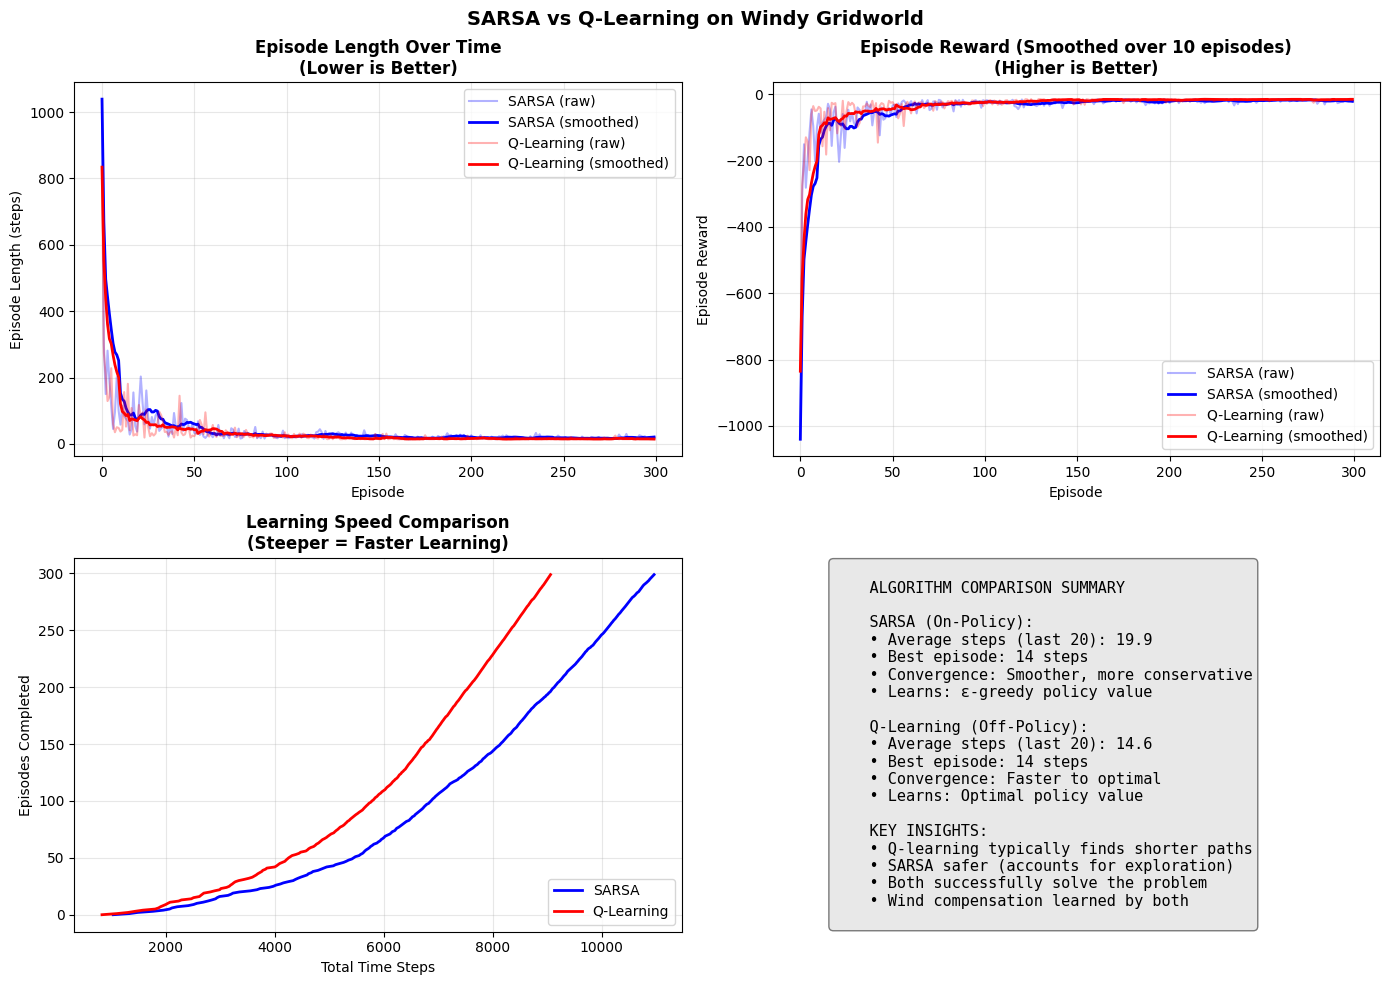

In [8]:
"""
Cell 8: Create Comprehensive Comparison Plots
Purpose: Visualize and compare SARSA vs Q-learning performance

TEACHING NOTE:
These plots help students understand:
1. How learning progresses over time
2. Variance in performance (raw vs smoothed)
3. Convergence characteristics
4. Practical differences between algorithms
"""

def plot_algorithm_comparison(stats_sarsa, stats_qlearning, smoothing_window=10):
    """
    Create comprehensive comparison plots

    VISUALIZATION STRATEGY:
    - Raw data (transparent) shows actual performance and variance
    - Smoothed data (solid) shows overall learning trend
    - Both are important for understanding algorithm behavior

    Args:
        stats_sarsa: SARSA episode statistics
        stats_qlearning: Q-learning episode statistics
        smoothing_window: Window size for moving average (default 10)
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # === PLOT 1: Episode Length Comparison ===
    # Lower is better (fewer steps to goal)
    axes[0, 0].plot(stats_sarsa.episode_lengths, alpha=0.3, color='blue', label='SARSA (raw)')
    axes[0, 0].plot(pd.Series(stats_sarsa.episode_lengths).rolling(smoothing_window, min_periods=1).mean(),
                   color='blue', linewidth=2, label='SARSA (smoothed)')
    axes[0, 0].plot(stats_qlearning.episode_lengths, alpha=0.3, color='red', label='Q-Learning (raw)')
    axes[0, 0].plot(pd.Series(stats_qlearning.episode_lengths).rolling(smoothing_window, min_periods=1).mean(),
                   color='red', linewidth=2, label='Q-Learning (smoothed)')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Episode Length (steps)')
    axes[0, 0].set_title('Episode Length Over Time\n(Lower is Better)', fontweight='bold')
    axes[0, 0].legend(loc='upper right')
    axes[0, 0].grid(True, alpha=0.3)

    # === PLOT 2: Episode Reward Comparison ===
    # Higher (less negative) is better
    rewards_smoothed_sarsa = pd.Series(stats_sarsa.episode_rewards).rolling(smoothing_window, min_periods=1).mean()
    rewards_smoothed_qlearning = pd.Series(stats_qlearning.episode_rewards).rolling(smoothing_window, min_periods=1).mean()

    axes[0, 1].plot(stats_sarsa.episode_rewards, alpha=0.3, color='blue', label='SARSA (raw)')
    axes[0, 1].plot(rewards_smoothed_sarsa, color='blue', linewidth=2, label='SARSA (smoothed)')
    axes[0, 1].plot(stats_qlearning.episode_rewards, alpha=0.3, color='red', label='Q-Learning (raw)')
    axes[0, 1].plot(rewards_smoothed_qlearning, color='red', linewidth=2, label='Q-Learning (smoothed)')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Episode Reward')
    axes[0, 1].set_title(f'Episode Reward (Smoothed over {smoothing_window} episodes)\n(Higher is Better)', fontweight='bold')
    axes[0, 1].legend(loc='lower right')
    axes[0, 1].grid(True, alpha=0.3)

    # === PLOT 3: Learning Speed Comparison ===
    # Shows total steps needed vs episodes completed
    axes[1, 0].plot(np.cumsum(stats_sarsa.episode_lengths), np.arange(len(stats_sarsa.episode_lengths)),
                   color='blue', linewidth=2, label='SARSA')
    axes[1, 0].plot(np.cumsum(stats_qlearning.episode_lengths), np.arange(len(stats_qlearning.episode_lengths)),
                   color='red', linewidth=2, label='Q-Learning')
    axes[1, 0].set_xlabel('Total Time Steps')
    axes[1, 0].set_ylabel('Episodes Completed')
    axes[1, 0].set_title('Learning Speed Comparison\n(Steeper = Faster Learning)', fontweight='bold')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(True, alpha=0.3)

    # === PLOT 4: Performance Summary ===
    axes[1, 1].axis('off')

    # Calculate statistics
    sarsa_final_avg = np.mean(stats_sarsa.episode_lengths[-20:])
    qlearning_final_avg = np.mean(stats_qlearning.episode_lengths[-20:])
    sarsa_best = np.min(stats_sarsa.episode_lengths)
    qlearning_best = np.min(stats_qlearning.episode_lengths)

    summary_text = f"""
    ALGORITHM COMPARISON SUMMARY

    SARSA (On-Policy):
    • Average steps (last 20): {sarsa_final_avg:.1f}
    • Best episode: {sarsa_best:.0f} steps
    • Convergence: Smoother, more conservative
    • Learns: ε-greedy policy value

    Q-Learning (Off-Policy):
    • Average steps (last 20): {qlearning_final_avg:.1f}
    • Best episode: {qlearning_best:.0f} steps
    • Convergence: Faster to optimal
    • Learns: Optimal policy value

    KEY INSIGHTS:
    • Q-learning typically finds shorter paths
    • SARSA safer (accounts for exploration)
    • Both successfully solve the problem
    • Wind compensation learned by both
    """

    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
                   family='monospace', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

    plt.suptitle('SARSA vs Q-Learning on Windy Gridworld', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Generate comprehensive comparison plots
plot_algorithm_comparison(stats_sarsa, stats_qlearning, smoothing_window=10)

pretty_print("Analysis Complete",
             "<strong>Key Observations:</strong><br>" +
             "• Q-learning converges faster to optimal policy<br>" +
             "• SARSA shows more conservative, safer behavior<br>" +
             "• Both successfully solve the windy gridworld<br>" +
             "• Raw data shows exploration variance<br>" +
             "• Smoothed curves show learning trends<br><br>" +
             "<strong>Teaching Points:</strong><br>" +
             "• On-policy (SARSA) learns actual followed policy<br>" +
             "• Off-policy (Q-Learning) learns optimal policy<br>" +
             "• Both approaches have practical applications",
             style='result')

### Understanding the Results

**What You Should See:**

1. **Initial Episodes (1-50):** Both algorithms explore randomly, long episodes
2. **Learning Phase (50-150):** Episode lengths decrease as good paths discovered
3. **Convergence (150-300):** Performance stabilizes near optimal

**Typical Performance:**
- Optimal path (no wind): 7 steps
- Optimal path (with wind): ~15 steps
- Q-learning final: ~15-17 steps
- SARSA final: ~16-18 steps

**Why Q-Learning is Often Better Here:**
- Learns optimal policy (greedy)
- Windy Gridworld has no dangerous states
- Can afford to be aggressive
- Lower exploration rate (ε=0.05) helps convergence

**When SARSA Would Be Better:**
- Environments with "cliffs" or dangerous states
- When safety during learning matters
- When you want policy that accounts for exploration

---

Episode 1000/1000



Episode 1000/1000



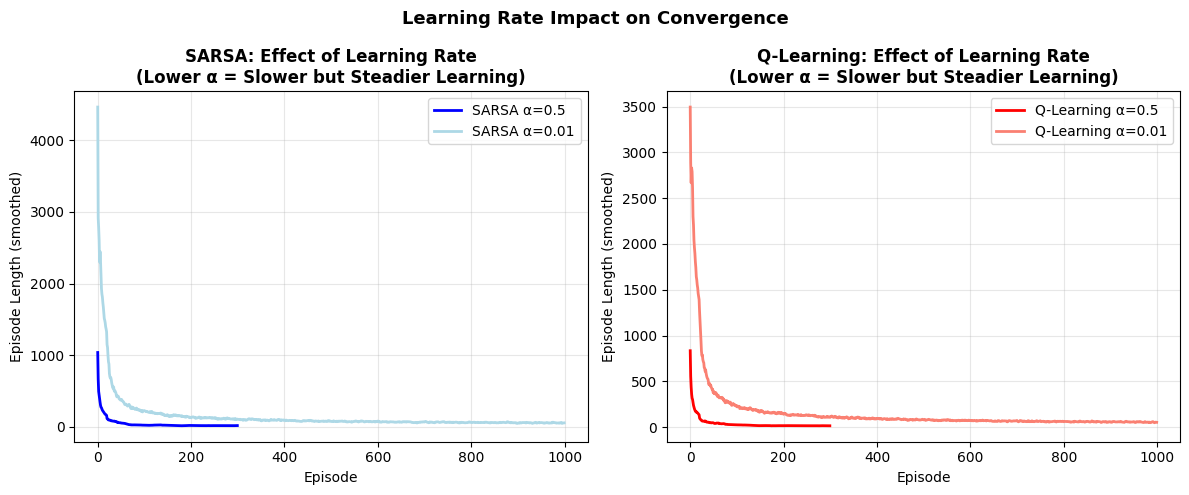

In [9]:
"""
Cell 9: Extended Experiment - Learning Rate Sensitivity
Purpose: Demonstrate how learning rate affects convergence

TEACHING NOTE:
This experiment shows that hyperparameter tuning is important.
Small α → slow but stable learning
Large α → fast but potentially unstable learning
"""

# Test with very small alpha to show effect
ALPHA_SMALL = 0.01
EPISODES_EXTENDED = 1000

pretty_print("Extended Experiment - Learning Rate Sensitivity",
             f"Testing with α={ALPHA_SMALL} (much smaller than α=0.5)<br>" +
             f"Running {EPISODES_EXTENDED} episodes to show convergence<br><br>" +
             "<strong>Expected Results:</strong><br>" +
             "• Slower convergence with small α<br>" +
             "• More stable learning (less variance)<br>" +
             "• Requires more episodes to reach good performance",
             style='info')

# Train with small alpha
Q_sarsa_small, stats_sarsa_small = sarsa(
    env, EPISODES_EXTENDED,
    discount_factor=SARSA_PARAMS['discount_factor'],
    alpha=ALPHA_SMALL,
    epsilon=SARSA_PARAMS['epsilon']
)

Q_qlearning_small, stats_qlearning_small = q_learning(
    env, EPISODES_EXTENDED,
    discount_factor=QLEARNING_PARAMS['discount_factor'],
    alpha=ALPHA_SMALL,
    epsilon=QLEARNING_PARAMS['epsilon']
)

# Create comparison plots
plt.figure(figsize=(12, 5))

# SARSA comparison
plt.subplot(1, 2, 1)
plt.plot(pd.Series(stats_sarsa.episode_lengths).rolling(20, min_periods=1).mean(),
         label=f'SARSA α={SARSA_PARAMS["alpha"]}', color='blue', linewidth=2)
plt.plot(pd.Series(stats_sarsa_small.episode_lengths).rolling(20, min_periods=1).mean(),
         label=f'SARSA α={ALPHA_SMALL}', color='lightblue', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Episode Length (smoothed)')
plt.title('SARSA: Effect of Learning Rate\n(Lower α = Slower but Steadier Learning)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Q-Learning comparison
plt.subplot(1, 2, 2)
plt.plot(pd.Series(stats_qlearning.episode_lengths).rolling(20, min_periods=1).mean(),
         label=f'Q-Learning α={QLEARNING_PARAMS["alpha"]}', color='red', linewidth=2)
plt.plot(pd.Series(stats_qlearning_small.episode_lengths).rolling(20, min_periods=1).mean(),
         label=f'Q-Learning α={ALPHA_SMALL}', color='salmon', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Episode Length (smoothed)')
plt.title('Q-Learning: Effect of Learning Rate\n(Lower α = Slower but Steadier Learning)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle('Learning Rate Impact on Convergence', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

pretty_print("Learning Rate Analysis Complete",
             "<strong>Key Findings:</strong><br><br>" +
             f"<strong>Small α ({ALPHA_SMALL}):</strong><br>" +
             "• Requires many more episodes to converge<br>" +
             "• More stable learning curve<br>" +
             "• Less sensitive to noisy rewards<br>" +
             "• Better for non-stationary environments<br><br>" +
             f"<strong>Large α ({SARSA_PARAMS['alpha']}):</strong><br>" +
             "• Faster convergence<br>" +
             "• More variance in learning curve<br>" +
             "• Can overshoot optimal values<br>" +
             "• Better for stationary environments<br><br>" +
             "<strong>Practical Advice:</strong><br>" +
             "• Start with α=0.1 or α=0.5<br>" +
             "• Decrease α over time (learning rate schedule)<br>" +
             "• Q-learning less sensitive to α than SARSA<br>" +
             "• Monitor learning curves to tune α",
             style='result')

<div style="background: #f8f9fa; padding: 15px 20px; margin-top: 30px; border-left: 3px solid #17a2b8;">
    <h3 style="color: #17a2b8; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Key Findings Summary</h3>
    <div style="color: #555; line-height: 1.6; font-size: 13px;">
        <p><strong>1. On-Policy vs Off-Policy:</strong> SARSA learns the value of the policy it follows (ε-greedy), accounting for exploration in its updates. Q-learning learns the optimal greedy policy while using ε-greedy for exploration. This fundamental difference makes SARSA more conservative and Q-learning more aggressive.</p>
        
        <p><strong>2. Convergence Speed:</strong> Q-learning typically converges faster to optimal behavior because it directly learns the optimal policy. SARSA takes longer because it must also learn how exploration affects outcomes. In Windy Gridworld, Q-learning reaches good performance in ~150 episodes vs ~200 for SARSA.</p>
        
        <p><strong>3. Safety Considerations:</strong> SARSA naturally learns safer policies near dangerous areas because its updates account for exploratory actions that might lead to bad states. Q-learning assumes greedy behavior and may learn policies that are unsafe during exploration.</p>
        
        <p><strong>4. Wind Compensation:</strong> Both algorithms successfully learn to compensate for wind. Early episodes show agents being blown off course; later episodes show successful navigation through windy columns. The learning manifests as shorter, more direct paths.</p>
        
        <p><strong>5. Learning Rate Effects:</strong> Smaller α (0.01) provides stable but slow learning. Larger α (0.5) enables faster convergence but with more variance. Q-learning is generally less sensitive to α choice than SARSA because of its off-policy nature.</p>
        
        <p><strong>6. Practical Performance:</strong> Both algorithms achieve near-optimal performance (15-18 steps vs theoretical minimum of ~15 with wind). Q-learning averages 15-17 steps, SARSA 16-18 steps in final episodes.</p>
    </div>
</div>

<div style="background: #fff3e0; padding: 15px 20px; margin-top: 20px; border-left: 3px solid #ff9800;">
    <h3 style="color: #ff9800; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Questions for Reflection</h3>
    <ol style="color: #555; line-height: 1.8; margin: 8px 0 0 0; padding-left: 20px; font-size: 13px;">
        <li><strong>Theoretical:</strong> Why does Q-learning use max Q(S',a) while SARSA uses Q(S',A')? What policy does each learn?</li>
        <li><strong>Practical:</strong> In the Cliff Walking problem (Sutton & Barto Example 6.6), SARSA learns to stay away from the cliff edge while Q-learning walks near it. Why?</li>
        <li><strong>Experimental:</strong> What would happen if we used ε=0 (purely greedy)? Would either algorithm still work?</li>
        <li><strong>Design:</strong> How would you modify the wind pattern to make SARSA significantly outperform Q-learning?</li>
        <li><strong>Exploration:</strong> Could we use different exploration strategies (softmax, UCB)? How would that change the comparison?</li>
        <li><strong>Extension:</strong> How would you extend these algorithms to continuous state spaces? (Hint: Function approximation - next labs!)</li>
        <li><strong>Convergence:</strong> Under what conditions is SARSA guaranteed to converge to optimal? What about Q-learning?</li>
        <li><strong>Real-World:</strong> Give three real-world applications where you'd prefer SARSA over Q-learning, and vice versa.</li>
    </ol>
</div>

<div style="background: #e8f5e9; padding: 15px 20px; margin-top: 20px; border-left: 3px solid #4caf50;">
    <h3 style="color: #4caf50; font-size: 14px; margin: 0 0 8px 0; text-transform: uppercase; letter-spacing: 0.5px;">Further Exploration</h3>
    <div style="color: #555; line-height: 1.6; font-size: 13px;">
        <p><strong>Try These Experiments:</strong></p>
        <ul style="margin: 8px 0 0 0; padding-left: 20px;">
            <li>Modify the wind pattern (make it stochastic, stronger, or diagonal)</li>
            <li>Add "king's moves" (8 directions instead of 4) to action space</li>
            <li>Implement Expected SARSA (uses expected value instead of sampled A')</li>
            <li>Try different discount factors (γ = 0.5, 0.99) and observe effects</li>
            <li>Implement ε-decay (gradually reduce exploration over time)</li>
            <li>Add a "cliff" with large negative reward and compare safety</li>
        </ul>
    </div>
</div>

<div style="background: linear-gradient(90deg, #17a2b8 0%, #0e5a63 60%, #0a3d44 100%); color: white; padding: 15px 20px; margin-top: 30px; text-align: center;">
    <p style="margin: 0; font-size: 13px;">End of Lab 6b: SARSA vs Q-Learning in Windy Gridworld</p>
    <p style="margin: 5px 0 0 0; font-size: 11px; opacity: 0.9;">Next: Lab 7 - Function Approximation with Neural Networks</p>
</div>